<a href="https://colab.research.google.com/github/AndySAnker/fast-MotEx/blob/main/fast_MotEx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to MotEx

## First import modules, set seed parameters and import functions

In [16]:
import numpy as np
import time
import matplotlib as mpl
import matplotlib.cm
from multiprocessing import Pool
from functools import partial
from google.colab import output, files
#!git clone https://github.com/AndySAnker/fast-MotEx.git

In [222]:
formfactor_dict = {
  "H": 1, "He": 2, "Li": 3, "Be": 4, "B": 5, "C": 6, "N": 7, "O": 8, "F": 9, "Ne": 10, "Na": 11, "Mg": 12,
  "Al": 13, "Si": 14, "P": 15, "S": 16, "Cl": 17, "Ar": 18, "K": 19, "Ca": 20, "Sc": 21, "Ti": 22, "V": 23, "Cr": 24,
  "Mn": 25, "Fe": 26, "Co": 27, "Ni": 28, "Cu": 29, "Zn": 30, "Ga": 31, "Ge": 32, "As": 33, "Se": 34, "Br": 35, "Kr": 36,
  "Rb": 37, "Sr": 38, "Y": 39, "Zr": 40, "Nb": 41, "Mo": 42, "Tc": 43, "Ru": 44, "Rh": 45, "Pd": 46, "Ag": 47, "Cd": 48,
  "In": 49, "Sn": 50, "Sb": 51, "Te": 52, "I": 53, "Xe": 54, "Cs": 55, "Ba": 56, "Hf": 72, "Ta": 73, "W": 74, "Re": 75,
  "Os": 76, "Ir": 77, "Pt": 78, "Au": 79, "Hg": 80, "Tl": 81, "Pb": 82, "Bi": 83, "Po": 84, "At": 85, "Rn": 86, "Fr": 87,
  "Ra": 88, "Rf": 104, "Db": 105, "Sg": 106, "Bh": 107, "Hs": 108, "Mt": 109, "Ds": 110, "Rg": 111, "Cn": 112, "Nh": 113, "Fl": 114,
  "Mc": 115, "Lv": 116, "Ts": 117, "Og": 118, "La": 57, "Ce": 58, "Pr": 59, "Nd": 60, "Pm": 61, "Sm": 62, "Eu": 63, "Gd": 64,
  "Tb": 65, "Dy": 66, "Ho": 67, "Er": 68, "Tm": 69, "Yb": 70, "Lu": 71, "Ac": 89, "Th": 90, "Pa": 91, "U": 92, "Np": 93,
  "Pu": 94, "Am": 95, "Cm": 96, "Bk": 97, "Cf": 98, "Es": 99, "Fm": 100, "Md": 101, "No": 102, "Lr": 103, "D": 1}

def Load(Experimental_Data, starting_model):
    """This function loads the data and structure"""
    
    # Get experimental data
    for skip_row in range(100):
        try:
            Exp_data = np.loadtxt(Experimental_Data, skiprows=skip_row)
        except ValueError:
            continue
    # Nyquist sampling the data by only using every 10nth datapoint
    if Exp_data[1,0] - Exp_data[0,0] < 0.1:
        Exp_r, Exp_Gr = Exp_data[::10,0], Exp_data[::10,1]
    else:
        Exp_r, Exp_Gr = Exp_data[:,0], Exp_data[:,1]
    # Normalise data
    Exp_Gr -= np.min(Exp_Gr)
    Exp_Gr /= np.trapz(Exp_Gr)
    
    # Read structure and divide it into two lists: Atoms we want to iterate (W) and atoms we do not iterate (O)
    struct=[]
    with open(starting_model, 'r') as fi:
        for line in fi.readlines():
            sep_line=line.strip('{}\n\r ').split()
            if len(sep_line)==4: #  tillader andre informationer i xyz filen some ikke skal laeses
                struct.append(sep_line)
    elements=np.array(struct)[:,0]
    xyz=(np.array(struct)[:,1:].astype(float))
    
    return Exp_r, Exp_Gr, elements, xyz

def fitting(structure_catalogue, formfactor_dict, Exp_r, Exp_Gr, elements, xyz, index):    
    """This function takes in a 'starting_model', and an 'index' from the 'structure_catalogue'. It generates the 
    corresponding structure and calculate the Rwp value to the 'Experimental_Data without fitting"""
    
    # Cycle through W atoms and delete W according to index 0's from permutation
    delete_M = np.where(np.array(structure_catalogue)[index,:] == 0)[0]
 
    # Delete atoms from starting model 
    elements = np.delete(elements, delete_M, 0)
    xyz = np.delete(xyz, delete_M, 0)
    elements = [int(formfactor_dict[element]) for element in elements]

    # Delete oxygen atoms that are to far away from metal atoms
    oxygens, non_oxygens = np.where(np.array(elements) == 8)[0], np.where(np.array(elements) != 8)[0]
    delete_oxygens = []
    for oxygen_atom in reversed(oxygens):
      dists = np.sqrt((xyz[oxygen_atom,0]-xyz[non_oxygens,0])**2+(xyz[oxygen_atom,1]-xyz[non_oxygens,1])**2+(xyz[oxygen_atom,2]-xyz[non_oxygens,2])**2)
      min_dist = min(dists)
      if min_dist > threshold:
        delete_oxygens.append(oxygen_atom)
    elements = np.delete(elements, delete_oxygens, 0)
    xyz = np.delete(xyz, delete_oxygens, 0)

    # Calculate distances and formfactor to simulate PDF
    i, j = np.triu_indices(len(xyz), k=1)
    dists = np.sqrt((xyz[i,0]-xyz[j,0])**2+(xyz[i,1]-xyz[j,1])**2+(xyz[i,2]-xyz[j,2])**2)
    formfactor = np.array(elements)[i] * np.array(elements)[j]
    normalisation_factor = np.array(np.mean(np.array(elements)) ** 2).repeat(len(j), axis=0)
    formfactor = np.array(formfactor) / np.array(normalisation_factor)
    
    # Simulate PDF
    Sim_Gr, Sim_r = np.histogram(np.array(dists, dtype=float), bins=len(Exp_r), range=[Exp_r[0]-0.05,Exp_r[-1]+0.05], weights=np.array(formfactor, dtype=float))
    Sim_r = (Sim_r[1:] + Sim_r[:-1]) / 2
    
    # Normalise PDF
    Sim_Gr = np.nan_to_num(Sim_Gr, 0)
    Sim_Gr -= np.min(Sim_Gr)
    Sim_Gr /= np.trapz(Sim_Gr)
    
    # Calculate Rwp value
    Rwp = np.sqrt(sum((Exp_Gr - Sim_Gr)**2) / sum((Exp_Gr)**2))
    
    return Rwp

def fitting_multiprocess(structure_catalogue, formfactor_dict, Exp_r, Exp_Gr, element, xyz, SaveName, cores=1):
    """This function runs the calculations of all the structures in the structure catalogue using multiprocessing"""

    values = []
    # Set up multiprocessing refinement
    fitindex = range(len(structure_catalogue))
    p = Pool(processes=cores)
    func = partial(fitting, structure_catalogue, formfactor_dict, Exp_r, Exp_Gr, element, xyz)
    results = p.map(func, fitindex)
    p.close()
    p.join()
    
    # Start calculating residuals and append results to lists
    for i in fitindex:
        rw = results[i]
        values.append(rw)
    values = np.reshape(values,(int(len(values)/1) , 1))
    
    # Save results 
    Result = np.column_stack([values, np.asarray(structure_catalogue)])
    np.savetxt(SaveName, Result)
    return Result

def structure_catalogue_maker(Number_of_atoms):
    """Makes a catalogue of structures"""
    structure_catalogue = np.ones((Number_of_atoms,Number_of_atoms))
    structure_catalogue[np.array([range(Number_of_atoms)]),np.array([range(Number_of_atoms)])] = 0
    return structure_catalogue

def calculate_atomContributionValue(Result, saveResults):
    """Calculate atom contribution value list from the result array"""
    
    # Define AtomContributionValues vector
    AtomContributionValues = Result[:,0]
    
    # Normalise the AtomContributionValues
    amin, amax = min(AtomContributionValues), max(AtomContributionValues)
    AtomContributionValues = (AtomContributionValues - amin) / (amax - amin)
    AtomContributionValues_ph = AtomContributionValues.copy()
    AtomContributionValues_ph.sort()

    # Define colormap of viridis.reverse
    #norm = mpl.colors.Normalize(vmin=AtomContributionValues_ph[round((len(AtomContributionValues))/10)], vmax=AtomContributionValues_ph[-round((len(AtomContributionValues))/10)])
    norm = mpl.colors.Normalize(vmin=min(AtomContributionValues), vmax=max(AtomContributionValues))
    cmap = matplotlib.cm.cividis_r
    m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # Save results to file
    f = open(saveResults+"AtomContributionValues.txt", "w")
    f.write("\nAtom contribution are calculated to: \n")
    for i in range(len(AtomContributionValues)):
        f.write("Atom # "+ str(i+1) + ":  "+ str(AtomContributionValues[i]) + "  Colorcode:  "+ mpl.colors.rgb2hex(m.to_rgba(AtomContributionValues[i]))+"\n")
    
    return m, AtomContributionValues

def Make_CrystalMakerFile(elements, xyz, AtomContributionValues, m, saveResults, threshold):
    # Read bonds and colors of all atoms
    bonding = []
    with open("fast-MotEx/utils/Bonding.txt", 'r') as fi:
        for line in fi.readlines():
            sep_line=line.strip('{}\n\r ').split()
            bonding.append(sep_line)
    bonding = np.array(bonding)
    
    # Output a crystalmaker file to visualize the results
    CrystalMaker = open(saveResults+'_CrystalMaker.cmtx', 'w')

    CrystalMaker.write("MOLE  CrystalMaker molecule format\n")
    CrystalMaker.write("TITL  Molecule\n\n")
    CrystalMaker.write("! Model type\n")
    CrystalMaker.write("MODL  1\n\n")

    CrystalMaker.write("! Depth fading settings\n")
    CrystalMaker.write("DCUE  1.000000 0.212899 0.704686\n\n")

    CrystalMaker.write("! Colour definitions:\n")
    CrystalMaker.write("TYPE\n")

    # Assign colors to all the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            #CrystalMaker.write(element + str(iter+1) + " 1.32 ")
            CrystalMaker.write(element + str(iter+1) + " " + bonding[np.where(bonding == element)[0][0], 1] + " ")
            rgb1 = m.to_rgba(AtomContributionValues[iter])[:-1][0]
            rgb2 = m.to_rgba(AtomContributionValues[iter])[:-1][1]
            rgb3 = m.to_rgba(AtomContributionValues[iter])[:-1][2]
            CrystalMaker.write(str(rgb1) + " " + str(rgb2) + " " + str(rgb3))
            CrystalMaker.write("\n")
        else:
            #CrystalMaker.write(element + str(iter+1) + " 0.66 ")
            CrystalMaker.write(element + str(iter+1) + " " + bonding[np.where(bonding == element)[0][0], 1] + " ")
            rgb1 = int(float(bonding[np.where(bonding == element)[0][0], 2])*255) #mpl.colors.to_rgb("#FF0000")[0]
            rgb2 = int(float(bonding[np.where(bonding == element)[0][0], 3])*255) #mpl.colors.to_rgb("#FF0000")[1]
            rgb3 = int(float(bonding[np.where(bonding == element)[0][0], 4])*255) #mpl.colors.to_rgb("#FF0000")[2]
            CrystalMaker.write(str(rgb1) + " " + str(rgb2) + " " + str(rgb3))
            CrystalMaker.write("\n")
    
    CrystalMaker.write("\n")
    CrystalMaker.write("! Atoms list\n")
    CrystalMaker.write("! Bond Specifications\n")
    
    # Assign bonds between the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            NI_elements = np.delete(np.unique(elements), np.where(np.unique(elements) == element)[0])
            for NI_element in NI_elements:
                CrystalMaker.write("BMAX " + element + " " + str(NI_element) + "  " + str(threshold))
                CrystalMaker.write("\n")
    
    CrystalMaker.write("\n")
    CrystalMaker.write("! Atoms list\n")
    CrystalMaker.write("ATOM\n")
    
    # Assign coordinates to the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            CrystalMaker.write(element + " " + element + str(iter+1) + " " + str(xyz[iter][0]) + " " + str(xyz[iter][1]) + " " + str(xyz[iter][2]) + "\n")
        else:
            CrystalMaker.write(element + " " + element + str(iter+1) + " " + str(xyz[iter][0]) + " " + str(xyz[iter][1]) + " " + str(xyz[iter][2]) + "\n")

    CrystalMaker.close()
    
    return None

def Make_VestaFile(elements, xyz, AtomContributionValues, m, saveResults, threshold):
    # Read bonds and colors of all atoms
    bonding = []
    with open("fast-MotEx/utils/Bonding.txt", 'r') as fi:
        for line in fi.readlines():
            sep_line=line.strip('{}\n\r ').split()
            bonding.append(sep_line)
    bonding = np.array(bonding)

    # Output a Vesta file to visualize the results
    Vesta = open(saveResults+'_Vesta.vesta', 'w')

    Vesta.write("#VESTA_FORMAT_VERSION 3.5.4\n\n\n")
    Vesta.write("MOLECULE\n\n")
    Vesta.write("Title\n")
    Vesta.write("XYZ file\n\n")

    Vesta.write("STRUC\n")
    # Assign coordinates to the atoms
    for iter, element in enumerate(elements):
        Vesta.write(str(iter+1) + " " + element + " " + element + str(iter+1) + " 1.0000 " + str(xyz[iter][0]) + " " + str(xyz[iter][1]) + " " + str(xyz[iter][2]) + "1" + " -" + "\n")
        Vesta.write("0 0 0 0\n")
    Vesta.write("  0 0 0 0 0 0 0\n")

    Vesta.write("SBOND\n")
    # Assign bonds between the atoms
    unique_elements = np.unique(elements)
    for iter, element1 in enumerate(unique_elements):
      for iter, element2 in enumerate(unique_elements):
        if not element1 == element2:
          Vesta.write(str(iter+1) + " " + element1 + " " + element2 + " 0.0 " + str(threshold) + " 0 1 1 0 1 0.25 2 127 127 127\n")
          Vesta.write("0 0 0 0\n")
    
    Vesta.write("SITET\n")
    # Assign colors to all the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            rgb1 = int(m.to_rgba(AtomContributionValues[iter])[:-1][0]*255)
            rgb2 = int(m.to_rgba(AtomContributionValues[iter])[:-1][1]*255)
            rgb3 = int(m.to_rgba(AtomContributionValues[iter])[:-1][2]*255)
            Vesta.write(str(iter+1) + " " + element + str(iter+1) + " " + bonding[np.where(bonding == element)[0][0], 1] + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " 204 0\n")
        else:
            rgb1 = int(float(bonding[np.where(bonding == element)[0][0], 2])*255)
            rgb2 = int(float(bonding[np.where(bonding == element)[0][0], 3])*255)
            rgb3 = int(float(bonding[np.where(bonding == element)[0][0], 4])*255)
            Vesta.write(str(iter+1) + " " + element + str(iter+1) + " " + bonding[np.where(bonding == element)[0][0], 1] + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " 204 0\n")
    Vesta.write("0 0 0 0 0 0\n")
    
    Vesta.write("ATOMT\n")
    done_deal_atoms = []
    for iter, element in enumerate(elements):
      if element not in done_deal_atoms:
        rgb1 = int(float(bonding[np.where(bonding == element)[0][0], 2])*255)
        rgb2 = int(float(bonding[np.where(bonding == element)[0][0], 3])*255)
        rgb3 = int(float(bonding[np.where(bonding == element)[0][0], 4])*255)
        Vesta.write(str(iter+1) + " " + element + " " + bonding[np.where(bonding == element)[0][0], 1] + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " 204\n")
        done_deal_atoms.append(element)
    Vesta.write("0 0 0 0 0 0\n")

    Vesta.close()
    
    return None
    

## Define variables

In [220]:
starting_model = list(files.upload())[0] # Name of the starting model file
NumW = 24 # Number of atoms that should be permuted in the starting model
StemName = list(files.upload())[0][:-3] # Upload PDF(s) from local computer
threshold = 2.6

Saving 109725.xyz to 109725 (10).xyz


Saving NiBulk.gr to NiBulk (1).gr


## Run

In [223]:
start_time = time.time()
# Step 1: Make the structure catalogue
structure_catalogue = structure_catalogue_maker(Number_of_atoms=NumW)
print ("Catalogue maker: ", time.time() - start_time)

### First define the experimental data path and the path you want the structure catalogue with fits to be saved
Experimental_Data = StemName+".gr" # Name of the experimental file
saveFits = StemName+".txt" # Name of the saved fits file
# Load data and start model
Exp_r, Exp_Gr, elements, xyz = Load(Experimental_Data, starting_model)
print ("Data loader: ", time.time() - start_time)

### Step 2: Produce organized structure catalogue with Rwp values
Result = fitting_multiprocess(structure_catalogue, formfactor_dict, Exp_r, Exp_Gr, elements, xyz, SaveName=saveFits, cores=None)
print ("Getting results: ", time.time() - start_time)

# Step 3: Calculate Atom Contribution values
m, AtomContributionValues = calculate_atomContributionValue(Result, "./")
print ("Calculating atom contribution values: ", time.time() - start_time)

# Step 4: Output a CrystalMaker file
Make_CrystalMakerFile(elements, xyz, AtomContributionValues, m, StemName, threshold)
Make_VestaFile(elements, xyz, AtomContributionValues, m, StemName, threshold)
print ("Output a CrystalMaker file: ", time.time() - start_time)

    

Catalogue maker:  0.00042176246643066406
Data loader:  5.083475112915039
Getting results:  5.219449043273926
Calculating atom contribution values:  5.229823350906372
Output a CrystalMaker file:  5.291613340377808


## Download results

In [224]:
# Download the latest results
files.download(StemName + '_CrystalMaker.cmtx')
files.download(StemName + '_Vesta.vesta')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# visualisation of the structure

In [ ]:
#%matplotlib widget
#!pip install ipympl ase nglview
from ase.visualize import view
from ase.io import read
from google.colab import output
from ipywidgets import interact, interactive
output.enable_custom_widget_manager()

def visualize_structure(max_AtomContributionValue):
  Structure_visualize = read(starting_model)
  for i in reversed(range(len(AtomContributionValues))):
      if AtomContributionValues[i] > max_AtomContributionValue:
        Structure_visualize.pop(i)
  return view(Structure_visualize, viewer="ngl")

#interactive(visualize_structure, max_AtomContributionValue=(0.0, 1.0))
visualize_structure(max_AtomContributionValue=0.465)

In [ ]:
#%matplotlib widget
#!pip install ipympl ase nglview
from ase.visualize import view
from ase.io import read
from google.colab import output
from ipywidgets import interact, interactive
from ase.visualize.plot import plot_atoms
output.enable_custom_widget_manager()

def visualize_structure(max_AtomContributionValue):
  Structure_visualize = read(starting_model)
  for i in reversed(range(len(AtomContributionValues))):
      if AtomContributionValues[i] > max_AtomContributionValue:
        Structure_visualize.pop(i)
  return plot_atoms(Structure_visualize, radii=0.5)
  

interactive(visualize_structure, max_AtomContributionValue=(0.0, 1.0))



interactive(children=(FloatSlider(value=0.5, description='max_AtomContributionValue', max=1.0), Output()), _do…

In [ ]:
import nglview
Structure_visualize = read(starting_model)
bom = view(Structure_visualize, viewer="ngl")
nglview.write_html("C60_a.html", bom)

In [ ]:
start_time = time.time()
index = 3
NumW = 36 # Number of atoms that should be permuted in the starting model

# Step 1: Make the structure catalogue
structure_catalogue = structure_catalogue_maker(Number_of_atoms=NumW)

### First define the experimental data path and the path you want the structure catalogue with fits to be saved
Experimental_Data = StemName+".gr" # Name of the experimental file
# Load data and start model
Exp_r, Exp_Gr, elements, xyz = Load(Experimental_Data, starting_model)

# Cycle through W atoms and delete W according to index 0's from permutation
delete_M = np.where(np.array(structure_catalogue)[index,:] == 0)[0]

# Delete atoms from starting model 
elements = np.delete(elements, delete_M, 0)
xyz = np.delete(xyz, delete_M, 0)
elements = [int(formfactor_dict[element]) for element in elements]

# Delete oxygen atoms that are to far away from metal atoms
oxygens, non_oxygens = np.where(np.array(elements) == 8)[0], np.where(np.array(elements) != 8)[0]
for oxygen_atom in reversed(oxygens):
  dists = np.sqrt((xyz[oxygen_atom,0]-xyz[non_oxygens,0])**2+(xyz[oxygen_atom,1]-xyz[non_oxygens,1])**2+(xyz[oxygen_atom,2]-xyz[non_oxygens,2])**2)
  min_dist = min(dists)
  if min_dist > threshold:
    elements = np.delete(elements, oxygen_atom, 0)
    xyz = np.delete(xyz, oxygen_atom, 0)

# Calculate distances and formfactor to simulate PDF
i, j = np.triu_indices(len(xyz), k=1)
dists = np.sqrt((xyz[i,0]-xyz[j,0])**2+(xyz[i,1]-xyz[j,1])**2+(xyz[i,2]-xyz[j,2])**2)
formfactor = np.array(elements)[i] * np.array(elements)[j]
normalisation_factor = np.array(np.mean(np.array(elements)) ** 2).repeat(len(j), axis=0)
formfactor = np.array(formfactor) / np.array(normalisation_factor)

print (time.time() - start_time)

3.855292558670044


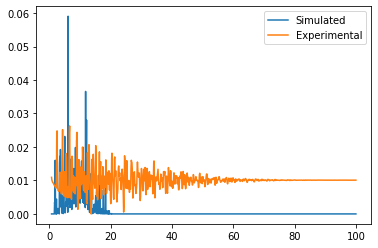

In [229]:
def Load(Experimental_Data, starting_model):
    """This function loads the data and structure"""
    
    # Get experimental data
    for skip_row in range(100):
        try:
            Exp_data = np.loadtxt(Experimental_Data, skiprows=skip_row)
        except ValueError:
            continue
    # Nyquist sampling the data by only using every 10nth datapoint
    if Exp_data[1,0] - Exp_data[0,0] < 0.1:
        Exp_r, Exp_Gr = Exp_data[::10,0], Exp_data[::10,1]
    else:
        Exp_r, Exp_Gr = Exp_data[:,0], Exp_data[:,1]
    # Normalise data
    Exp_Gr -= np.min(Exp_Gr) 
    Exp_Gr /= np.trapz(Exp_Gr) #abs(np.mean(Exp_Gr))
    
    # Read structure and divide it into two lists: Atoms we want to iterate (W) and atoms we do not iterate (O)
    struct=[]
    with open(starting_model, 'r') as fi:
        for line in fi.readlines():
            sep_line=line.strip('{}\n\r ').split()
            if len(sep_line)==4: #  tillader andre informationer i xyz filen some ikke skal laeses
                struct.append(sep_line)
    elements=np.array(struct)[:,0]
    xyz=(np.array(struct)[:,1:].astype(float))
    
    return Exp_r, Exp_Gr, elements, xyz
    
def structure_catalogue_maker(Number_of_atoms):
    """Makes a catalogue of structures"""
    structure_catalogue = np.ones((1+Number_of_atoms,Number_of_atoms))
    structure_catalogue[1+np.array([range(Number_of_atoms)]),np.array([range(Number_of_atoms)])] = 0
    return structure_catalogue

def fitting(structure_catalogue, formfactor_dict, Exp_r, Exp_Gr, elements, xyz, index):    
    """This function takes in a 'starting_model', and an 'index' from the 'structure_catalogue'. It generates the 
    corresponding structure and calculate the Rwp value to the 'Experimental_Data without fitting"""
    
    # Cycle through W atoms and delete W according to index 0's from permutation
    delete_M = np.where(np.array(structure_catalogue)[index,:] == 0)[0]
 
    # Delete atoms from starting model 
    elements = np.delete(elements, delete_M, 0)
    xyz = np.delete(xyz, delete_M, 0)
    elements = [int(formfactor_dict[element]) for element in elements]

    # Delete oxygen atoms that are to far away from metal atoms
    oxygens, non_oxygens = np.where(np.array(elements) == 8)[0], np.where(np.array(elements) != 8)[0]
    delete_oxygens = []
    for oxygen_atom in reversed(oxygens):
      dists = np.sqrt((xyz[oxygen_atom,0]-xyz[non_oxygens,0])**2+(xyz[oxygen_atom,1]-xyz[non_oxygens,1])**2+(xyz[oxygen_atom,2]-xyz[non_oxygens,2])**2)
      min_dist = min(dists)
      if min_dist > threshold:
        delete_oxygens.append(oxygen_atom)
    elements = np.delete(elements, delete_oxygens, 0)
    xyz = np.delete(xyz, delete_oxygens, 0)

    # Calculate distances and formfactor to simulate PDF
    i, j = np.triu_indices(len(xyz), k=1)
    dists = np.sqrt((xyz[i,0]-xyz[j,0])**2+(xyz[i,1]-xyz[j,1])**2+(xyz[i,2]-xyz[j,2])**2)
    formfactor = np.array(elements)[i] * np.array(elements)[j]
    normalisation_factor = np.array(np.mean(np.array(elements)) ** 2).repeat(len(j), axis=0)
    formfactor = np.array(formfactor) / np.array(normalisation_factor)
    
    # Simulate PDF
    Sim_Gr, Sim_r = np.histogram(np.array(dists, dtype=float), bins=len(Exp_r), range=[Exp_r[0]-0.05,Exp_r[-1]+0.05], weights=np.array(formfactor, dtype=float))
    Sim_r = (Sim_r[1:] + Sim_r[:-1]) / 2
    
    # Normalise PDF
    Sim_Gr = np.nan_to_num(Sim_Gr, 0)
    Sim_Gr -= np.min(Sim_Gr)
    Sim_Gr /= np.trapz(Sim_Gr) #abs(np.mean(Sim_Gr))
    
    # Calculate Rwp value
    Rwp = np.sqrt(sum((Exp_Gr - Sim_Gr)**2) / sum((Exp_Gr)**2))
    
    return Rwp, Sim_r, Sim_Gr, Exp_r, Exp_Gr


# Step 1: Make the structure catalogue
structure_catalogue = structure_catalogue_maker(Number_of_atoms=NumW)

### First define the experimental data path and the path you want the structure catalogue with fits to be saved
Experimental_Data = StemName+".gr" # Name of the experimental file
saveFits = StemName+".txt" # Name of the saved fits file
# Load data and start model
Exp_r, Exp_Gr, elements, xyz = Load(Experimental_Data, starting_model)

### Step 2: Produce organized structure catalogue with Rwp values
Rwp, Sim_r, Sim_Gr, Exp_r, Exp_Gr = fitting(structure_catalogue, formfactor_dict, Exp_r, Exp_Gr, elements, xyz, index=8)

import matplotlib.pyplot as plt
plt.plot(Sim_r, Sim_Gr, label="Simulated")
plt.plot(Exp_r, Exp_Gr*10, label="Experimental")
plt.legend()
plt.show()

In [226]:
Sim_Gr_Keggin = Sim_Gr

In [228]:
Sim_Gr_Keggin_Middle = Sim_Gr

In [230]:
Sim_Gr_Keggin_Outer = Sim_Gr

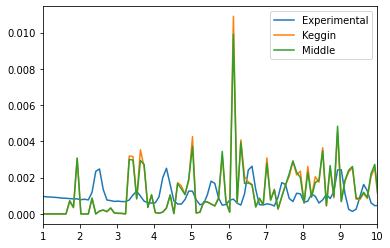

In [232]:
#plt.plot(Sim_r, Sim_Gr_C60 - Sim_Gr_C60, label="C60")
plt.plot(Exp_r, Exp_Gr, label="Experimental")
plt.plot(Sim_r, Sim_Gr_Keggin*0.2, label="Keggin")
#plt.plot(Sim_r, Sim_Gr_Keggin_Outer*0.2, label="Outer")
plt.plot(Sim_r, Sim_Gr_Keggin_Middle*0.2, label="Middle")
plt.xlim(1, 10)
plt.legend()
plt.show()

In [231]:
Rwp_Keggin = np.sqrt(sum((Exp_Gr - Sim_Gr_Keggin)**2) / sum((Exp_Gr)**2))
Rwp_Middle = np.sqrt(sum((Exp_Gr - Sim_Gr_Keggin_Middle)**2) / sum((Exp_Gr)**2))
Rwp_Outer = np.sqrt(sum((Exp_Gr - Sim_Gr_Keggin_Outer)**2) / sum((Exp_Gr)**2))
Rwp_Keggin, Rwp_Middle, Rwp_Outer    

(3.5851399901647887, 3.5008523514490113, 3.6649341435659344)

In [75]:
Sim_Gr_C60 - Sim_Gr_C60_30

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.0176053 ,
        0.00310682, -0.00621363,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.02796135, -0.00207121,
        0.0186409 ,  0.0176053 , -0.00828484,  0.00310682,  0.03003256,
       -0.01242727,  0.        , -0.00414242, -0.01656969,  0.        ,
       -0.02071211,  0.04867346,  0.07249239, -0.02071211, -0.02485453,
        0.00932045,  0.10045374, -0.02485453, -0.02071211, -0.02071211,
        0.08181284, -0.00724924, -0.01242727,  0.02071211,  0.00207121,
        0.00517803, -0.04349544,  0.02692575,  0.00310682, -0.00207121,
        0.0745636 ,  0.05695831, -0.06213634,  0.07870603, -0.01346287,
       -0.0362462 ,  0.04660225,  0.04453104,  0.00207121, -0.00517803,
        0.08699087, -0.03417499,  0.12427267, -0.02174772,  0.02692575,
        0.03313938, -0.06213634, -0.01346287, -0.02589014,  0.09838253,
        0.00621363, -0.01242727, -0.03003256,  0.00103561,  0.06